# Covid-19 Situation Report

Simon Ellersgaard Nielsen, July 2, 2020

Abstract: With the rise of the novel coronavirus pandemic came great intrigue followed by resounding ennui. Hordes of data scientists pored over covid-related data sets hoping to extract insights for the sake of public health or personal glory, creating vast online resources in the process. Noticing a certain lack of interplay between the infection related data and the policy related data, I decided to bridge the gap by creating the following notebook. 

Data is sourced from the University of Oxford:

https://ourworldindata.org/coronavirus

https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker

## Load Libraries:

In [86]:
# Required modules

import pandas as pd
import numpy as np 
import copy as copy
import matplotlib.pyplot as plt
import statsmodels.api as sm

from matplotlib.ticker import MaxNLocator
from datetime import date
from pylab import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## Data Retrieval Functions:

In [30]:
# Load covid case/fatility time series
def get_automatic():
    
    cases = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv",header=0)
    cases.date = pd.to_datetime(cases.date,format="%Y-%m-%d")
    cases.index = cases.date
    cases = cases.drop(['date'],axis=1)
    
    deaths = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_deaths.csv",header=0)
    deaths.date = pd.to_datetime(deaths.date,format="%Y-%m-%d")
    deaths.index = deaths.date
    deaths = deaths.drop(['date'],axis=1)

    return cases.ffill(), deaths.ffill()


# Load policy time series
def get_policy():
    
    return pd.read_csv("https://oxcgrtportal.azurewebsites.net/api/CSVDownload",header=0) 


# Load population numbers
def get_population():
    
    dp = pd.read_csv('https://datahub.io/JohnSnowLabs/population-figures-by-country/r/population-figures-by-country-csv.csv',header=0,index_col='Country')
    dp = dp.drop(dp.columns[:-1],axis=1)
    return dp.rename(columns={'Year_2016':'Population'})

## Data Processing Functions:

In [31]:
# Today's frame
def todays_data(ncases):
    
    ddf = pd.DataFrame(index=cases.columns, columns=['country','cases','deaths','total','ratio','SE'])                  
    for c in cases.columns:
        N = cases[c][-1]
        dr = 100.0*deaths[c][-1]/N
        ddf.loc[c,'country'] = c
        ddf.loc[c,'cases'] = N
        ddf.loc[c,'deaths'] = deaths[c][-1]
        ddf.loc[c,'total'] = N-deaths[c][-1]
        ddf.loc[c,'ratio'] = dr
        SE = 2*np.sqrt(dr*(100.0-dr)/N)
        ddf.loc[c,'SE'] = SE
    
    ddf = ddf[~ddf['ratio'].isnull()]
    ddf = ddf[ddf['cases'] > ncases]
    
    ddf = ddf.merge(pop_df,how='left',left_index=True,right_index=True)
    
    return ddf


# Extract case/fatality numbers for a single country c
def prepare_data(c):

    cc = cases[c].to_frame().rename(columns={c:'c_cases'})
    dc = deaths[c].to_frame().rename(columns={c:'c_deaths'})
    data = cc.merge(dc,how='left',left_index=True,right_index=True)
    data['d_cases'] = data['c_cases'].diff()
    data['d_deaths'] = data['c_deaths'].diff()
    data.loc[data['c_cases'].notna().idxmax(),'d_cases'] = data.loc[data['c_cases'].notna().idxmax(),'c_cases']
    data.loc[data['c_deaths'].notna().idxmax(),'d_deaths'] = data.loc[data['c_deaths'].notna().idxmax(),'c_deaths']
    
    data['days'] = (data.index-data.index[-1])
    data['days'] = (data['days']/np.timedelta64(1, 'D')).astype(int)
    
    data['cl_cases'] = np.log(data['c_cases'])
    data['cl_deaths'] = np.log(data['c_deaths'])
    data['c_deaths'][data['c_deaths']==0]=np.nan
    data['cl_deaths'][data['cl_deaths']<0]=np.nan
    
    data = data.interpolate()
    
    return data


# Extract policy numbers for a single country c
def prepare_gov(c):

    dfp = policy_df[policy_df['CountryName']==c].copy()
    dfp = dfp.sort_values(by=['Date'])
    dfp.index = pd.to_datetime(dfp['Date'],format='%Y%m%d')
    
    ilist = ['C1_School closing',
           'C2_Workplace closing', 
           'C3_Cancel public events', 
           'C4_Restrictions on gatherings',
           'C5_Close public transport', 
           'C6_Stay at home requirements', 
           'C7_Restrictions on internal movement', 
           'C8_International travel controls']
      
    dfp = dfp[ilist]
    dfp[ilist] = dfp[ilist].ffill()
    
    return dfp, ilist


## Inspecting the Data:

In [13]:
cases, deaths = get_automatic()

In [16]:
cases.tail()

,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2020-06-28,9953229,30616.0,2330.0,12968.0,855.0,244.0,3.0,65.0,57731.0,24645.0,...,81.0,924.0,7725.0,12.0,5130.0,354.0,208.0,1103.0,1531.0,567.0
2020-06-29,10113462,30967.0,2402.0,13273.0,855.0,267.0,3.0,65.0,57731.0,25127.0,...,81.0,929.0,8031.0,12.0,5297.0,355.0,208.0,1118.0,1557.0,567.0
2020-06-30,10273424,31238.0,2466.0,13571.0,855.0,276.0,3.0,66.0,62255.0,25127.0,...,84.0,932.0,8298.0,12.0,5530.0,355.0,208.0,1128.0,1568.0,574.0
2020-07-01,10465987,31517.0,2535.0,13907.0,855.0,284.0,3.0,66.0,64517.0,25542.0,...,84.0,936.0,8627.0,12.0,5832.0,355.0,380.0,1158.0,1594.0,591.0
2020-07-02,10665255,31836.0,2580.0,14272.0,855.0,291.0,3.0,66.0,67184.0,26065.0,...,92.0,943.0,8904.0,12.0,6062.0,355.0,461.0,1190.0,1632.0,605.0


In [17]:
deaths.tail()

,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2020-06-28,498550,703.0,53.0,892.0,52.0,10.0,0.0,3.0,1207.0,426.0,...,6.0,26.0,20.0,0.0,42.0,0.0,1.0,296.0,21.0,6.0
2020-06-29,501597,721.0,55.0,897.0,52.0,11.0,0.0,3.0,1217.0,433.0,...,6.0,27.0,22.0,0.0,44.0,0.0,1.0,302.0,22.0,6.0
2020-06-30,505309,733.0,58.0,905.0,52.0,11.0,0.0,3.0,1280.0,433.0,...,6.0,27.0,24.0,0.0,48.0,0.0,1.0,304.0,22.0,7.0
2020-07-01,511045,746.0,62.0,912.0,52.0,13.0,0.0,3.0,1307.0,443.0,...,6.0,27.0,26.0,0.0,51.0,0.0,1.0,312.0,24.0,7.0
2020-07-02,515964,774.0,65.0,920.0,52.0,15.0,0.0,3.0,1351.0,453.0,...,6.0,28.0,26.0,0.0,54.0,0.0,1.0,318.0,30.0,7.0


In [18]:
policy_df = get_policy()

In [21]:
policy_df.head()

,CountryName,CountryCode,Date,C1_School closing,C1_Flag,C1_Notes,C2_Workplace closing,C2_Flag,C2_Notes,C3_Cancel public events,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,20200101,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,20200102,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,20200103,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,20200104,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,20200105,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
pop_df = get_population()

In [27]:
pop_df.head()

,Population
Country,
Aruba,104822.0
Afghanistan,34656032.0
Angola,28813463.0
Albania,2876101.0
Andorra,77281.0


## Some Parameters:

In [102]:
tl = pd.to_datetime(cases.index[-1]).strftime('%Y-%m-%d') # Last observation date
ncases = 20000 # Filter out data with less than this number of confirmed cases
country_list = ['World','United Kingdom','United States','Canada','Italy','Spain','France',
                'Germany','Sweden','Norway','Denmark','Russia','India','Brazil'] # Countries we wish to look at
lw = 0.8 # Linewidth for plot
win1 = 120 # Past history for country specific plot
win2 = 20 # Future history for country specific plot
pdays = win1 
fs = 8 # Fontsize

## Get today's frame:

In [52]:
ddf = todays_data(ncases)

In [53]:
ddf.head()

,country,cases,deaths,total,ratio,SE,Population
World,World,10665255,515964,10149291,4.8378,0.0131402,7.442136e+09
Afghanistan,Afghanistan,31836,774,31062,2.43121,0.172638,3.465603e+07
Argentina,Argentina,67184,1351,65833,2.0109,0.108313,4.384743e+07
Armenia,Armenia,26065,453,25612,1.73796,0.161888,2.924816e+06
Bahrain,Bahrain,27414,92,27322,0.335595,0.0698589,1.425171e+06


## Total Confirmed Cases/Deaths:

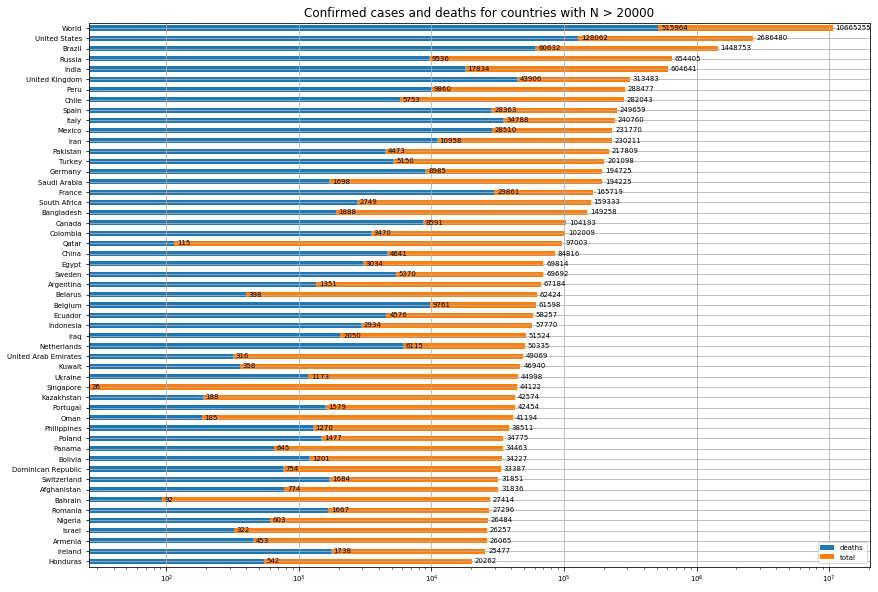

In [54]:
ddf1 = ddf.copy()     
ddf1 = ddf1.sort_values(by=['cases']) 
ddf1 = ddf1[ddf1['cases'] > ncases]
ddf1[['deaths','total']].plot(kind='barh', stacked=True, figsize=(14, 10))
ax = plt.gca()
ax.set_xscale('log')
ax.tick_params(axis='both',labelsize=7)
ax.grid(True)
ax.set_title('Confirmed cases and deaths for countries with N > {:}'.format(ncases))
for i, v in enumerate(ddf1['cases'].values):
    ax.text(v*1.05, i-0.15, str(int(v)), color='k',fontsize=7)
for i, v in enumerate(ddf1['deaths'].values):
    ax.text(v*1.05, i-0.15, str(int(v)), color='k',fontsize=7)
ax.legend(loc='lower right',fontsize=7)

Note: the x-axis is on a logarithmic scale.

## Per Capita Evaluation:

Text(0.5, 1.0, 'Per Capita Report for N > 20000')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


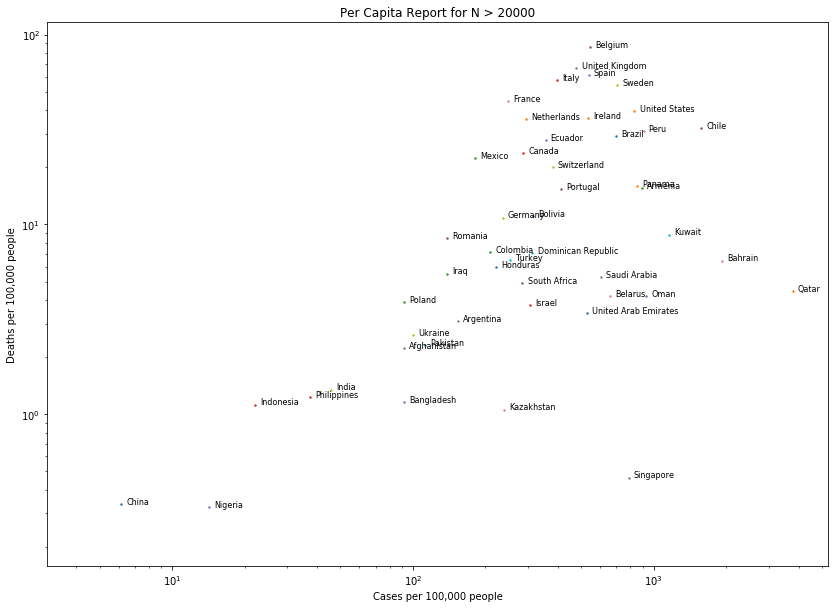

In [90]:
ddf12 = ddf1.copy()
ddf12['cases/pop'] = 100000*ddf12['cases']/ddf12['Population']
ddf12['deaths/pop'] = 100000*ddf12['deaths']/ddf12['Population']
ddf12 = ddf12.drop(['World'],axis=0)

fig, ax = plt.subplots(1,1,figsize=(14, 10))

for c in ddf12.index:
    try:
        ax.scatter(ddf12.at[c,'cases/pop'],ddf12.at[c,'deaths/pop'],s=2)
        ax.text(ddf12.at[c,'cases/pop']*1.05,ddf12.at[c,'deaths/pop'], c, color='k',fontsize=8)
    except:
        pass
              
ax.set_yscale('log')
ax.set_xscale('log')    
ax.set_xlabel('Cases per 100,000 people')
ax.set_ylabel('Deaths per 100,000 people')
ax.set_title('Per Capita Report for N > {:}'.format(ncases))

Note: double logarithmic plot. Many developing countries lie low on their counts, which arguably is an artefact of insufficient diagnostics.

## On Mortality:

Throughout this note, we shall approximate the mortality ratio as the total number of confirmed covid deaths (observed up to time t) divided by the total number of confirmed cases (observed up to time t). Evidently this procedure is marred by two (at least partially offsetting) errors. (i) Far from everybody who gets covid will get formally tested (denominator should be greater). (ii) People don't die instantaneously from covid (the numerator should be greater).

Controlled evidence from the Diamond Princess suggests the true mortality rate could be lower than 1%.

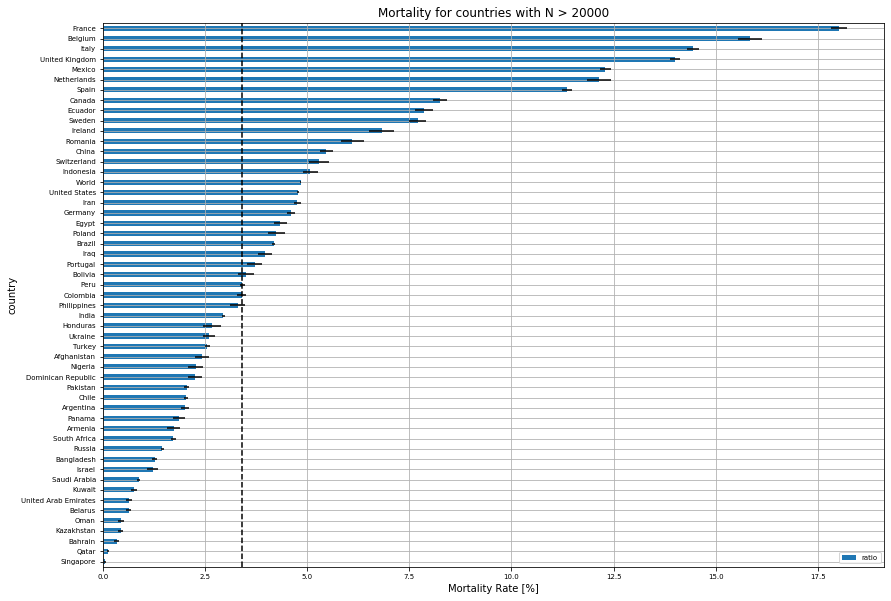

In [60]:
ddf = ddf.sort_values(by=['ratio'])
ddf.plot.barh(x='country', y='ratio',xerr=ddf['SE'].values, figsize=(14, 10))
ax = plt.gca()
ax.tick_params(axis='both',labelsize=7)
ax.set_xlabel('Mortality Rate [%]')
ax.axvline(ddf['ratio'].median(), ls='--', color='k')
ax.grid(True)
ax.set_title('Mortality for countries with N > {:}'.format(ncases))
ax.legend(loc='lower right',fontsize=7)

## Deceleration Monitor:

In the early stages of transmission in which the growth pattern is exponential the total reported cases is necessarily proportional to the total reported cases over (say) the past week. This fact is helpful when assessing whether a country is showing signs of controlling the virus (indeed: whether it is losing control again). 

In the plot below, you would want to see the historical growth pattern of a country race towards the bottom. 

(100, 5631742.538426938)

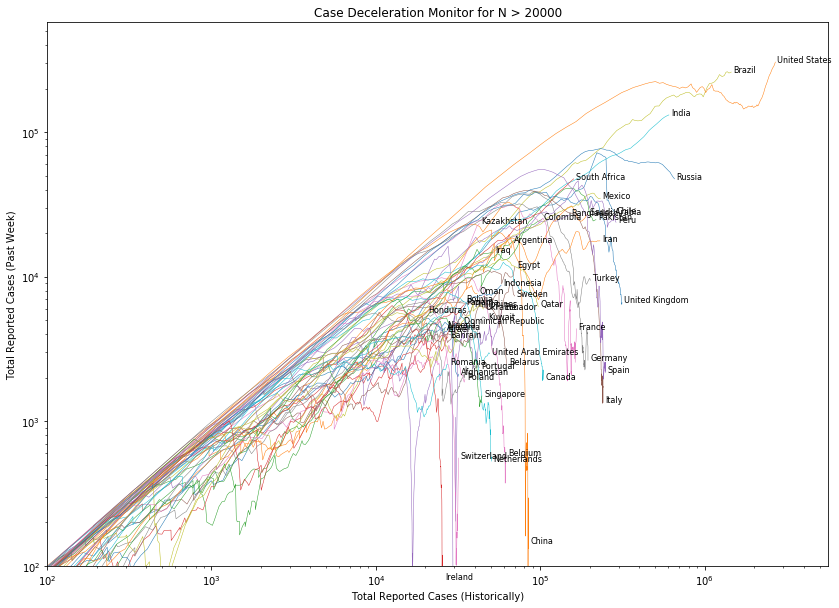

In [63]:

df_N = cases[cases.columns[(cases.iloc[-1]>ncases).values]].copy()
df_N = df_N.drop(['World'],axis=1)
df_N2 = df_N - df_N.shift(7)

df_N2[df_N2<1]=np.nan

fig, ax = plt.subplots(1,1,figsize=(14, 10))

for n in df_N.columns:
    
    ax.plot(df_N[n].values,df_N2[n].values,linewidth=0.5)
    ax.text(df_N[n][-1]*1.03,df_N2[n][-1], n, color='k',fontsize=8)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Total Reported Cases (Historically)')
ax.set_ylabel('Total Reported Cases (Past Week)')
ax.set_title('Case Deceleration Monitor for N > {:}'.format(ncases))
ax.set_ylim(bottom=100)
ax.set_xlim(left=100)

## Retrieve Country-specific Dictionaries:

In [91]:
if country_list[0] == 'World':
    country_list2 = country_list[1:]
else:
    country_list2 = country_list

nd_c = {}
for c in country_list:
    
    nd_c[c] = prepare_data(c)

nd_p = {}
for c in country_list2:
    
    nd_p[c], ilist = prepare_gov(c)

## Comparative Country Evolution:

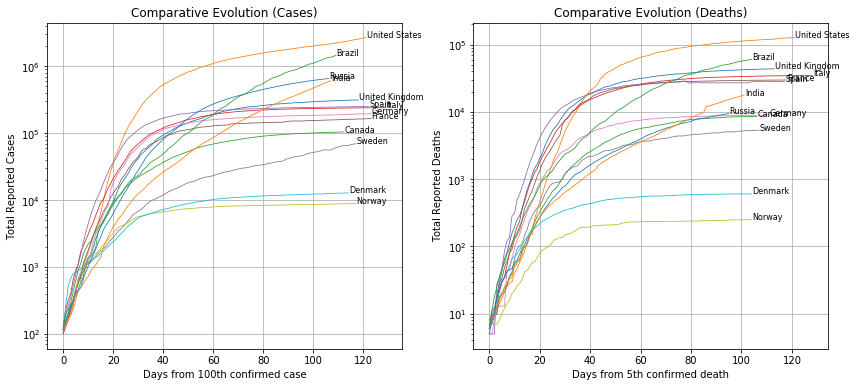

In [72]:

if len(country_list) > 1:

    fig, ax = plt.subplots(1,2,figsize=(14, 6))
    for c in country_list:
        
        mp = nd_c[c]
        
        if c != 'World':
            mp2 = mp[mp['c_cases']>=100].copy()
            mp2['days'] = mp2['days']-mp2['days'][0]
            ax[0].plot(mp2['days'].values,mp2['c_cases'].values, linewidth=lw)
            ax[0].text(mp2['days'][-1]+0.3,mp2['c_cases'][-1], c, color='k',fontsize=8)
          
    ax[0].set_yscale('log')
    ax[0].grid(True)
    ax[0].set_xlabel('Days from 100th confirmed case')
    ax[0].set_ylabel('Total Reported Cases')
    ax[0].set_title('Comparative Evolution (Cases)')


    for c in country_list:
        
        mp = nd_c[c]
        
        if c != 'World':
            mp2 = mp[mp['c_deaths']>=5].copy()
            mp2['days'] = mp2['days']-mp2['days'][0]
            ax[1].plot(mp2['days'].values,mp2['c_deaths'].values, linewidth=lw)
            ax[1].text(mp2['days'][-1]+0.3,mp2['c_deaths'][-1], c, color='k',fontsize=8)
          
    ax[1].set_yscale('log')
    ax[1].grid(True)
    ax[1].set_xlabel('Days from 5th confirmed death')
    ax[1].set_ylabel('Total Reported Deaths')
    ax[1].set_title('Comparative Evolution (Deaths)')
    


## Functions to Plot Country Specific Evolution:

We need two functions to plot the country specific evolutions:
    
The first function generates 
(1,1) The cumulative confirmed # cases, and the cumulative # deaths. A simple linear extrapolation based on recent observations is included.
(1,2) The mortality ratio, defined as above.
(2,1) The daily # of confirmed cases/deaths. Note: due to errors in the data this can be negative.
(2,2) The daily replicator, defined as cumulative cases at time t divided by cumulative cases at time t-1. For exponential growth this would be a constant. Thus, a decreasing function here indicates tapering off.

The second function generates the policy tools implemented over time (defined in terms of stringency buckets 1 to 3). See the Oxford University reference for a formal definition of what this means. It also plots the daily replicator and superimposes on top of it a polynomial fit generated using scikit learn. It goes without saying that the curve fitting should be taken with a pinch of salt.

In [92]:
# Plot country covid evolution
def plot_my_country(country):

    fig, ax = plt.subplots(2,2)
    fig.set_size_inches(14, 10)
    cdt = nd_c[country]

    try:
    
        cdt2 = cdt.iloc[-win1:].copy()
        
        # Model growth of confirmed cases with exponential fit
        dc = 5 
        X = sm.add_constant(cdt2['days'][-dc:], prepend=False)
        y = cdt2['cl_cases'][-dc:]
        mod = sm.OLS(y, X)
        res = mod.fit()
        #print(res.summary()) #enable to print stats
        
        # Model growth of confirmed deaths with exponential fit
        Xd = sm.add_constant(cdt2['days'][-dc:], prepend=False)
        yd = cdt2['cl_deaths'][-dc:]
        not_me = yd.isnull()
        yd = yd[~not_me]
        Xd = Xd[~not_me]
        modd = sm.OLS(yd, Xd)
        resd = modd.fit()
        #print(resd.summary()) # enable to print stats
        
        la = res.params.const
        lb = res.params.days
        lad = resd.params.const
        lbd = resd.params.days
        
        # Plot cumulative evolution/deaths with forecast
        ax[0][0].scatter(cdt2['days'].values,cdt2['c_cases'].values,linewidth=2,c='k',s=1,label='Confirmed: {:}'.format(int(cdt2['c_cases'][-1])))
        ax[0][0].scatter(cdt2['days'].values,cdt2['c_deaths'].values,linewidth=2,c='r',s=1,label='Dead: {:}'.format(int(cdt2['c_deaths'][-1])))
        x_line = np.arange(0,cdt2['days'].iloc[-1]+win2)
        
        a = np.exp(la)
        b = np.exp(lb)
        y_pred2 = a*b**(x_line)
        ad = np.exp(lad)
        bd = np.exp(lbd)
        y_pred2d = ad*bd**(x_line)
        
        ax[0][0].plot(x_line,y_pred2,c='grey',linewidth=lw,label = r'${:.2f}*{:.2f}^t$, $R^2$ = {:.2f}'.format(a,b,res.rsquared))
        ax[0][0].plot(x_line,y_pred2d,c='coral',linewidth=lw,label = r'${:.2f}*{:.2f}^t$, $R^2$ = {:.2f}'.format(ad,bd,resd.rsquared))
        ax[0][0].plot([0,0],[100,100.001],linewidth=0.1)
        ax[0][0].set_yscale('log')
        ax[0][0].set_xlabel('Days from {:}'.format(tl),fontsize=fs)
        ax[0][0].set_ylabel('Total Recorded Cases, c(t), and Deaths, d(t)',fontsize=fs)
        ax[0][0].grid(True)
        ax[0][0].legend(loc='lower right',fontsize=fs-1)
        ax[0][0].tick_params(axis='both',labelsize=fs)
        
        # Plot mortality ratio
        DR = 100.0*(cdt2['c_deaths']/cdt2['c_cases'])
        ax[0][1].plot(cdt2['days'].values,DR.values,'r',linewidth=lw,label = 'ratio: {:.2f}'.format(DR[-1]))
        ax[0][1].set_ylabel('Mortality Rate d(t)/c(t) [%]',fontsize=fs)
        ax[0][1].set_xlabel('Days from {:}'.format(tl),fontsize=fs)
        ax[0][1].grid(True)
        ax[0][1].xaxis.set_major_locator(MaxNLocator(integer=True))
        ax[0][1].legend(loc='upper left',fontsize=fs-1)
        ax[0][1].tick_params(axis='both',labelsize=fs)
        
        # Plot daily observed cases
        ax[1][0].plot(cdt2['days'].values,cdt2['d_cases'].values,'k',linewidth=lw,label = 'Confirmed: {:.0f}'.format(cdt2['d_cases'][-1]))
        ax[1][0].plot(cdt2['days'].values,cdt2['d_deaths'].values,'r',linewidth=lw,label = 'Dead: {:.0f}'.format(cdt2['d_deaths'][-1]))
        ax[1][0].set_ylabel('Daily Increase = c(t)-c(t-1)',fontsize=fs)
        ax[1][0].set_xlabel('Days from {:}'.format(tl),fontsize=fs)
        ax[1][0].grid(True)
        ax[1][0].xaxis.set_major_locator(MaxNLocator(integer=True)) 
        ax[1][0].legend(loc='upper left',fontsize=fs-1)
        ax[1][0].tick_params(axis='both',labelsize=fs)
          
        #Plot growth factor    
        cdt2['drep'] = cdt2['c_cases']/(cdt2['c_cases'].shift(1))
        ax[1][1].plot(cdt2['days'].values,cdt2['drep'].values,'k',linewidth=lw,label = 'Factor increase: {:.2f}'.format(cdt2['drep'][-1]))
        ax[1][1].axhline(b, color='grey',linewidth=lw,label='Fitted growth factor')
        ax[1][1].set_ylabel('Daily Replicator = c(t)/c(t-1) ',fontsize=fs)
        ax[1][1].set_xlabel('Days from {:}'.format(tl),fontsize=fs)
        ax[1][1].grid(True)
        ax[1][1].xaxis.set_major_locator(MaxNLocator(integer=True)) 
        ax[1][1].legend(loc='upper left',fontsize=fs-1)
        ax[1][1].tick_params(axis='both',labelsize=fs)
        
        fig.suptitle('{:}, Date {:}'.format(country,tl), fontsize=12)
        
    except:
        pass
            

In [93]:
# Plot policy tools + scikit fit
def plot_policy(country):
    
    try:
    
        dat3 = nd_c[country].merge(nd_p[country],how='left',left_index=True,right_index=True)
        dat3[ilist] = dat3[ilist].ffill()
        dat3['replicator'] = dat3['c_cases']/(dat3['c_cases'].shift(1))
        dat3.index = dat3['days']
        dat3 = dat3[-pdays:]
        dat3 = dat3.replace([np.inf, -np.inf], np.nan)
        dat3 = dat3[~dat3['replicator'].isnull()]

        # Plot policy tools
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(14, 10)
        dat3[ilist].plot.area(ax=ax,linewidth=1,alpha=0.5)
        ax.set_ylabel('Classification',fontsize=fs)
        ax.grid(True)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(loc='upper left',fontsize=fs)
        ax.set_xlabel('Days from {:}'.format(tl),fontsize=fs)
        ax.set_title('{:}, Date {:}'.format(country,tl), fontsize=12)

        # Plot daily replicator
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Daily Replicator = c(t)/c(t-1)', color=color,fontsize=fs)  
        ax2.scatter( dat3['replicator'].index,dat3['replicator'].values,c=color,s=4)
        ax2.tick_params(axis='y', labelcolor=color)

        # Fit polynomial function to daily replicator using scikit pipeline. Use boot-strapping to create confidence band
        X_pred0 = dat3['days'].values
        X_pred = dat3['days'].values.reshape(-1,1) 
        X = dat3['days'].astype(float).values.reshape(-1,1) 
        y = dat3['replicator'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)         

        pipe = make_pipeline(
                StandardScaler(),
                PolynomialFeatures(),
                Ridge())

        param_grid = {'polynomialfeatures__degree': [1,2,3,4,5,6,7],
                      'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

        grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
        grid.fit(X_train, y_train)

        ND = pd.DataFrame(index = X_pred0)
        for mc in range(0,200):
            sample_index = np.random.choice(range(0,len(y)),len(y))
            X_s = X[sample_index]
            y_s = y[sample_index]

            model = make_pipeline(PolynomialFeatures(grid.best_params_['polynomialfeatures__degree']), Ridge(grid.best_params_['ridge__alpha']))
            model.fit(X_s, y_s)
            y_p = model.predict(X_pred)  
            ND[mc] = y_p

        ND['lower'] = ND.quantile(0.025,axis=1)
        ND['upper'] = ND.quantile(0.975,axis=1)
        ND['median'] = ND.quantile(0.5,axis=1)

        ax2.plot(X_pred,ND['median'].values,color=color,linewidth=1,label='{:}'.format(grid.best_params_))
        ax2.plot(X_pred,ND['upper'].values,color=color,linewidth=1,linestyle=':')
        ax2.plot(X_pred,ND['lower'].values,color=color,linewidth=1,linestyle=':')
        ax2.legend(loc='upper right',fontsize=fs)
    
    except:
        pass

## World:

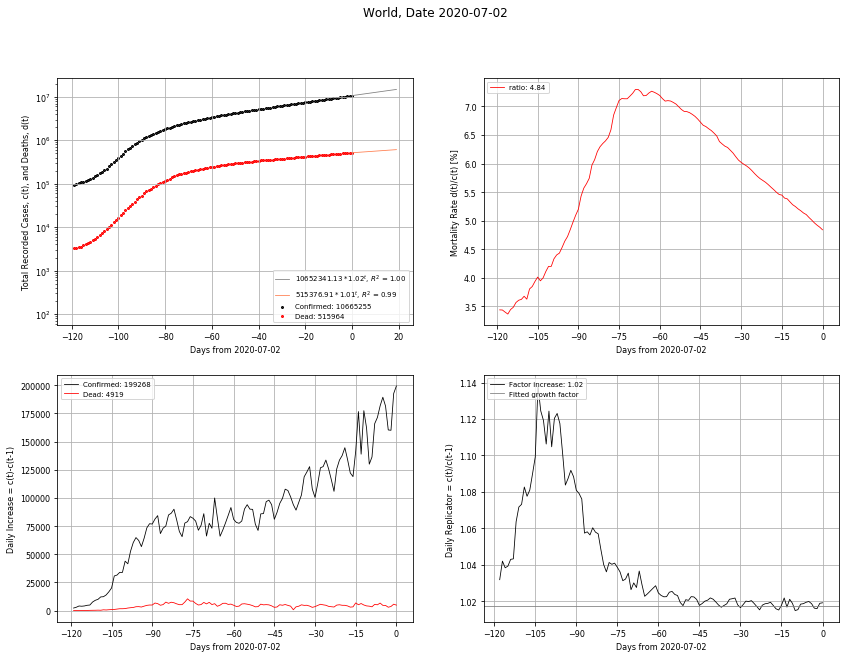

In [94]:
plot_my_country('World')

## United Kingdom:

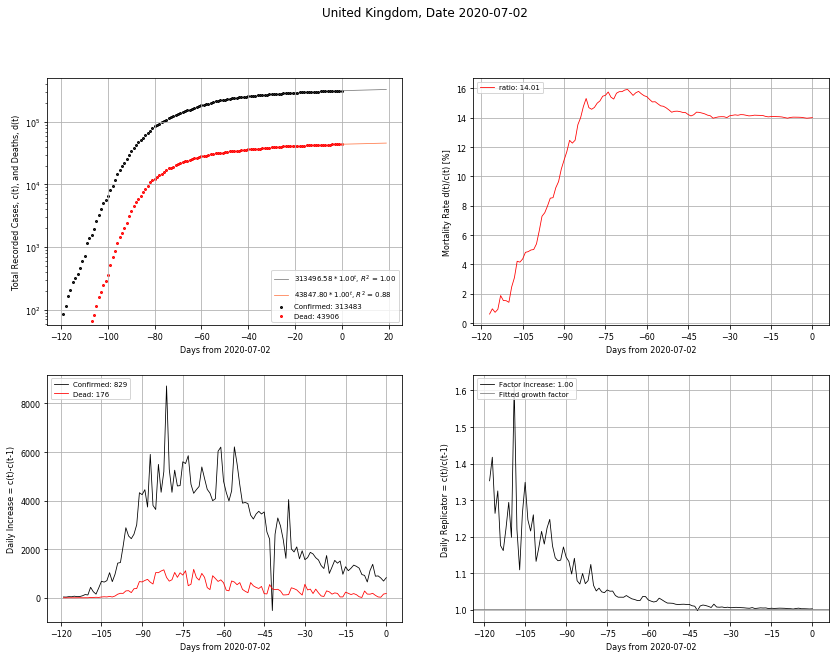

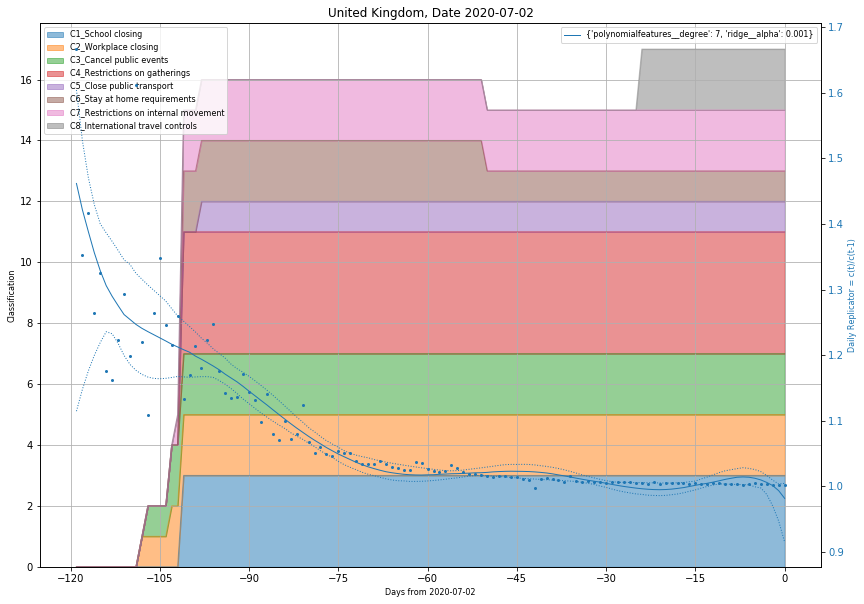

In [95]:
plot_my_country('United Kingdom')
plot_policy('United Kingdom')

## United States:

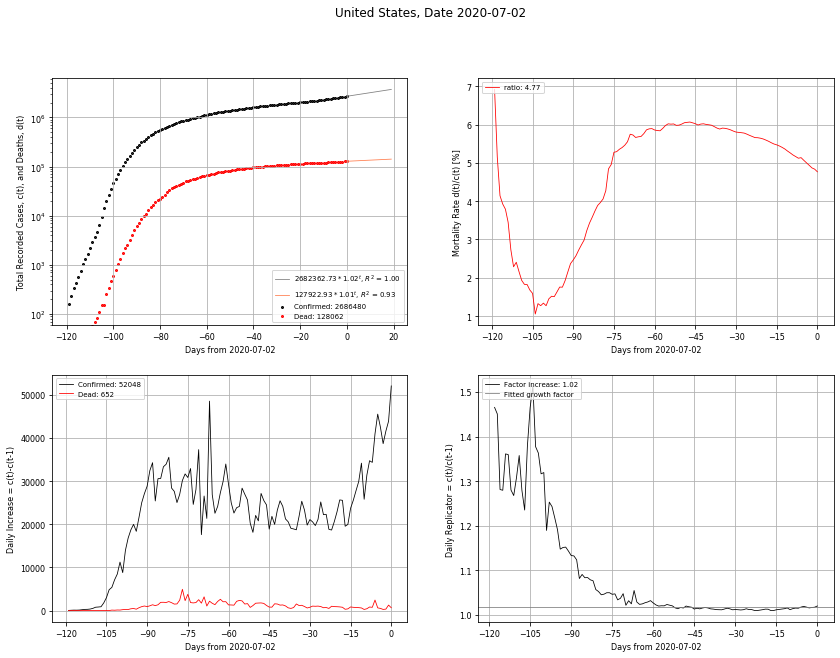

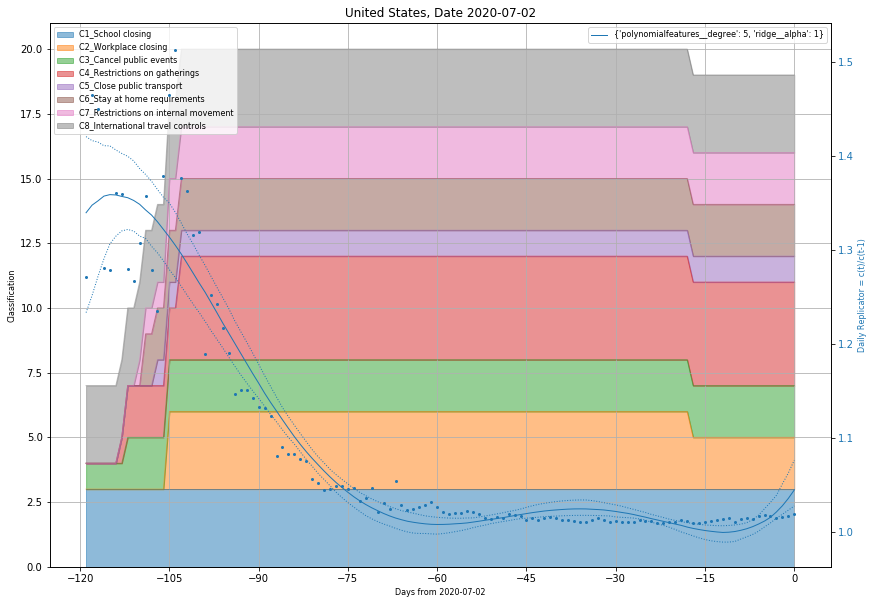

In [96]:
plot_my_country('United States')
plot_policy('United States')

## Russia:

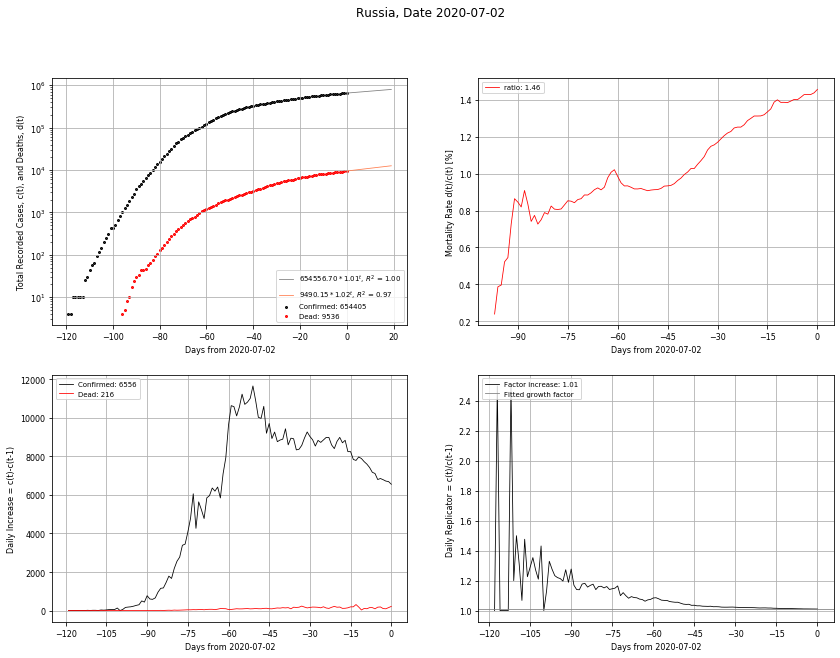

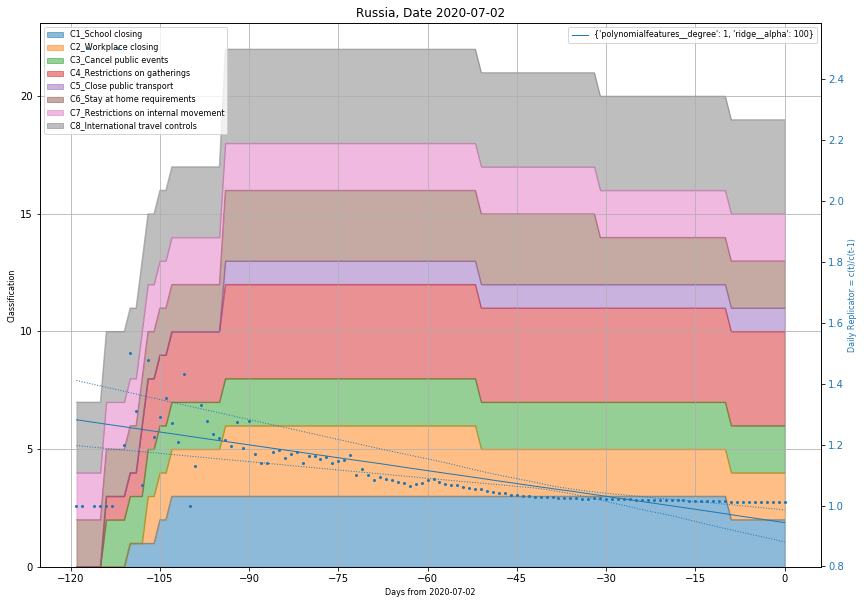

In [97]:
plot_my_country('Russia')
plot_policy('Russia')

## India:

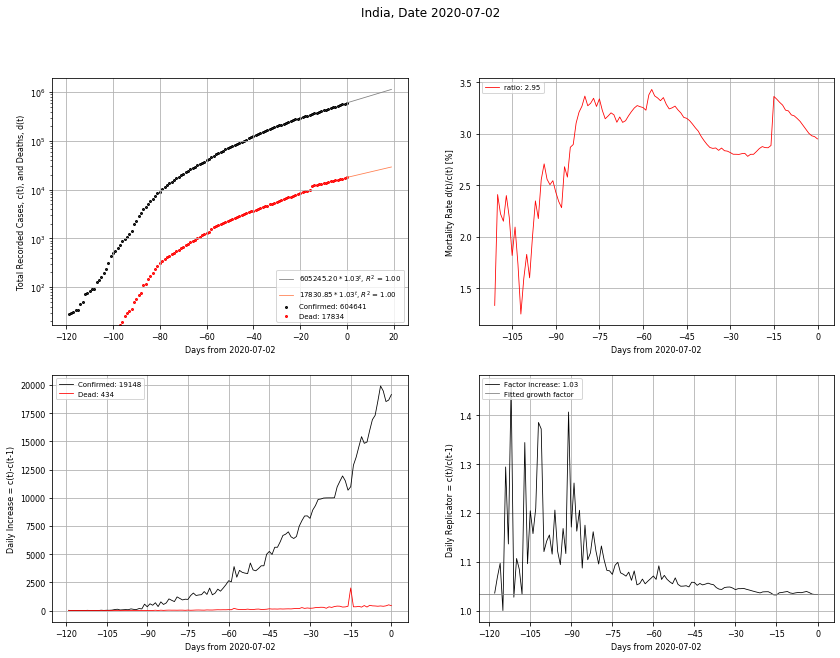

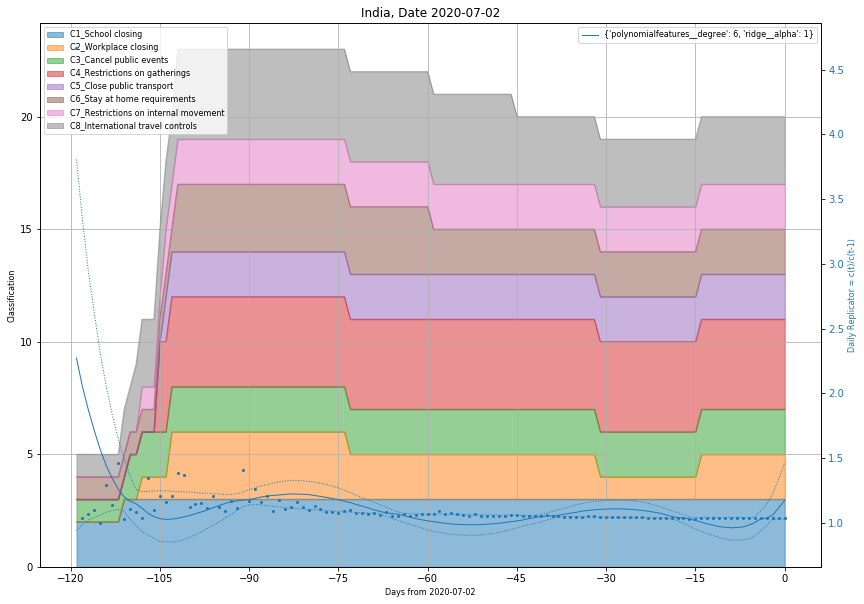

In [99]:
plot_my_country('India')
plot_policy('India')

## Brazil:

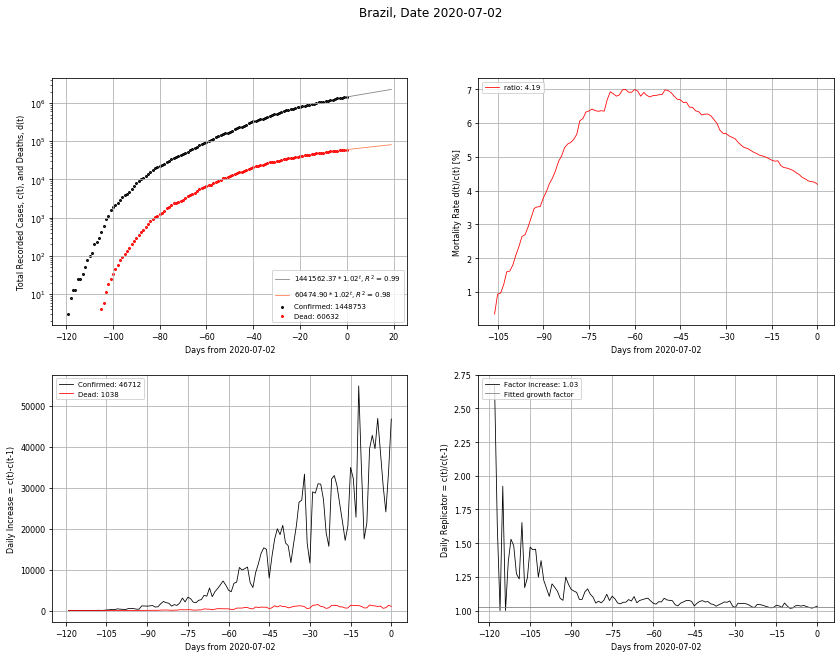

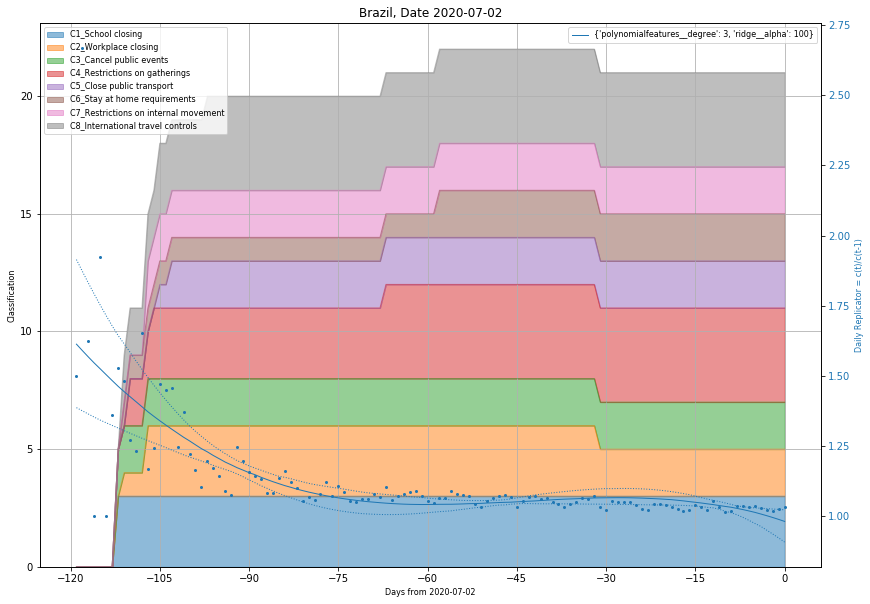

In [101]:
plot_my_country('Brazil')
plot_policy('Brazil')